In [1]:
import os
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
os.name

'posix'

In [2]:
def get_manta_files(folder="C:\\YandexDisk\\_QUT\\Project_1\\MAntas_imag\\0_manta_selected_annotated_some",
             pics_extension=('.jpg','.jpeg','.png')):
    '''
    getting collection of pictures with information regarding available lable file *.json
    the labelling was performed using "label me" tool https://github.com/wkentaro/labelme
    assuming that relevant label file has same name as image file and locatet in the same folder
    @params:
        folder:string
        pics_extension: iterable
        
    Oputputs:
        df : pandas.DataFrame
    '''
    
    if os.name=="nt":
        delim="\\"
    else:
        delim="/"
    
    df=pd.DataFrame(columns=['manta_name','file_name','image_path','body_landmark_path'])
    for dirname, dirnames, filenames in os.walk(folder):
        if len(filenames)>0:
            for f in filenames:
                if os.path.splitext(f)[1].lower() in pics_extension:
                    #print(os.path.splitext(f)[0].lower()+".json")
                    #print(set(filenames))
                    if os.path.splitext(f)[0]+".json" in set(filenames):
                        #print ("yes")
                        json_file=dirname+delim+os.path.splitext(f)[0]+".json"
                    else:
                        json_file=None
                    df.loc[len(df)]=[os.path.basename(dirname),os.path.splitext(f)[0],dirname+delim+f,json_file]
    print('total:'+str(len(df)))
    print('labelled:'+str(len(df[df.body_landmark_path.isnull()!=True])))
    return df

In [3]:
if os.name=="nt":
    folder="C:\\YandexDisk\\_QUT\\Project_1\\MAntas_imag\\0_manta_selected_annotated_some"
else:
    folder="/tf/notebooks/data/0_manta_selected_annotated_some"

heatmap_order=("left-eye","right-eye","left-gill","right-gill","tail")
print ("os = "+os.name)
df=get_manta_files(folder=folder)
df.head(3)

os = posix
total:1801
labelled:295


,manta_name,file_name,image_path,body_landmark_path
0,0837,837-F-20150603-AM-LEI-KathyTownsend--1,/tf/notebooks/data/0_manta_selected_annotated_...,None
1,0837,837-F-20130915-1212-LEI-MichelleOoi--1,/tf/notebooks/data/0_manta_selected_annotated_...,None
2,0837,837-F-20130915-1212-LEI-FrazerMcGregor--2,/tf/notebooks/data/0_manta_selected_annotated_...,None


In [4]:
print("labelled pictures")
df[df.body_landmark_path.isna()==False].index

labelled pictures


Int64Index([  13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
            ...
            1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747],
           dtype='int64', length=295)

In [6]:
def distance(points):
    #returns eucledian distance for two n-dimentional points 
    a,b=points
    from scipy.spatial import distance
    return distance.euclidean(a, b)

def extract_body_landmarks(json_filename):
    '''extracts body-landmarks from json file
       @params:
           json_filename:string
       output - Dictionary:
           "height-width": tuple(height,width) of the source image
           "BLM"  : List of tuples. Each tuple is a body-landmark:
               (label,(x,y),r)
    '''
    if json_filename is None:
        return None
    
    with open(json_filename,'r',encoding='utf-8') as j:
              data=json.load(j)
    shapes=data['shapes']
    height_width=[data['imageHeight'],data['imageWidth']]
    
    json_info = {}
    json_info["height_width"] = height_width
    BLM=[]
    for t in shapes:
        label=t['label']
        point=np.array(t['points'][0][::-1])
        r=round(distance(t['points']))
        BLM.append((label,point,r))
    json_info["BLM"]=BLM
    return json_info

In [7]:
#New architecture
def gen_heatmaps(json_info,heatmap_size):
    '''
    produces array of pairs {heatmap_label:heatmap}
    @params: Dictionary:   (output from "extract_body_landmarks" )
           "height-width": tuple(height,width) of the source image
           "BLM"  : List of tuples. Each tuple is a body-landmark:
               (label,(x,y),r)
    outputs:
        numpy (heatmap_size[0],heatmap_size[1],5)
    '''
    heatmap_order=("left-eye","right-eye","left-gill","right-gill","tail")
    if json_info is None:
        return None
    BLMs=json_info["BLM"]
    height_width=json_info["height_width"]
    heatmaps={}
    for poi in BLMs:
        poi_label=poi[0]
        point=np.array(poi[1])
        r=poi[2]

        heatmap=np.zeros(heatmap_size)
        scales=[]
        for d1,d2 in zip(height_width,heatmap_size):
            scales.append(d2/d1)
        scales=np.array(scales)
        newpoint=np.round(point*scales,0).astype(int)
        new_r=round(r*scales[0]).astype(int)*2
        if new_r==0: 
            new_r=2
        for x in range(heatmap_size[0]):
            for y in range(heatmap_size[1]):
                d=distance([newpoint,[x,y]])
                heatmap[x,y]=1/(2+(d/new_r)**2)

        #heatmaps["label"]=poi_label
        heatmaps[poi_label]=heatmap
    #convert to numpy
    output_heatmaps=[]
    for label in heatmap_order:
        if label in heatmaps:
            output_heatmaps.append(heatmaps[label])
        else:
            output_heatmaps.append(np.zeros(heatmap_size))
    output_heatmaps=np.array(output_heatmaps)
    #channels - last
    output_heatmaps=np.moveaxis(output_heatmaps,0,-1)
    return output_heatmaps

In [8]:
def apply_heatmaps(image,heatmaps):
    '''
    shows image and it's heatmaps
    @params:
        image:PIL.Image
        heatmaps: Manta Heatmaps list
    '''
    heatmap_order=("left-eye","right-eye","left-gill","right-gill","tail")
    #convert to channels-first
    heatmaps=np.moveaxis(heatmaps,-1,0)
    image_size=(heatmaps[0].shape[::-1])
    #resize the image to size of heatmap
    image = image.resize(image_size, Image.ANTIALIAS)
    
    img=np.array(image)
    img= img/255

    base_mask=np.zeros_like(heatmaps[0])
    #summarise all heatmaps into one
    
    base_mask=heatmaps.sum(axis=0)
    #we want RED heatmap, so we have to add zero channels for Green and blue
    base_mask=base_mask.reshape(base_mask.shape[0],base_mask.shape[1],1)
    green=np.zeros_like(base_mask)
    blue=np.zeros_like(base_mask)
    mask=np.append(base_mask,green,axis=2)
    mask=np.append(mask,blue,axis=2)

    newpic=(base_mask<0.01)*img + (base_mask>=0.01)*(img*(1-base_mask) + mask)
    plt.imshow(newpic)
    #add anotations
    for i,heatmap in zip(range(len(heatmaps)),heatmaps):
        label=heatmap_order[i]
        if heatmap.sum()>0: #if jeatmap is not blank
            #find center of heatmap
            center=np.argmax(heatmap)
            x=center//heatmap.shape[0]
            y=center%heatmap.shape[1]  
            plt.annotate(label,xy=(y+5,x))

/tf/notebooks/data/0_manta_selected_annotated_some/0046 Freyja/46-F-20130418-1421-LEI-RyanJeffery-FREYJA.json
{'BLM': [('left-eye', array([1331, 1995]), 25.0), ('left-gill', array([1800, 1803]), 23.0), ('tail', array([2465, 1715]), 21.0), ('right-eye', array([1597, 2618]), 25.0), ('right-gill', array([1976, 2271]), 15.0)], 'height_width': [3264, 4352]}


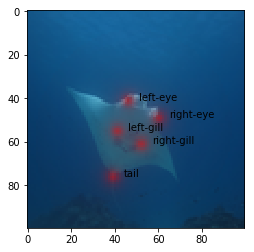

In [30]:
pic_to_show=26

image_path=df.image_path[pic_to_show]
jpath=df.body_landmark_path[pic_to_show]
#jpath="C:\\YandexDisk\\_QUT\\Project_1\\MAntas_imag\\0_manta_selected_annotated_some\\0012 Laverna\\12-F-20130627-LEI-MichelleOoi-LAVERNA-2.json"
print(jpath)
json_info = extract_body_landmarks(jpath)
print(json_info)
heatmaps=gen_heatmaps(json_info,(100,100))
from PIL import Image
image = Image.open(image_path)
apply_heatmaps(image,heatmaps)
#plt.imshow(image)

In [29]:
def normalize(imag):
        image=np.array(imag)
        image = image[..., ::-1]
        image = image.astype('float')

        image[..., 0] -= 103.939
        image[..., 1] -= 116.779
        image[..., 2] -= 123.68
        return image
    
def denormalize(imag):
        image=imag
        image[..., 0] += 103.939
        image[..., 1] += 116.779
        image[..., 2] += 123.68
        image = image[..., ::-1]
        image = image.astype('uint8')
        image=Image.fromarray(image)
        return image 
    
def image_to_numpy(image,image_size):
    image = image.resize(image_size, Image.ANTIALIAS)
    image=normalize(image)
    return image

In [31]:
npim=image_to_numpy(image,(100,100))

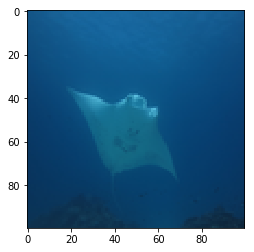

In [32]:
denim=denormalize(npim)
plt.imshow(denim)

In [33]:
heatmaps=heatmaps[:,:,:2]
heatmaps.shape

(100, 100, 2)

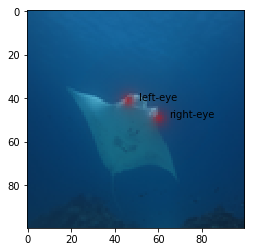

In [34]:
apply_heatmaps(denim,heatmaps)